In [555]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import torch
import math
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
import time

In [556]:
with open("data/game_idx.txt") as f:
    game_idx = int(f.read())
    print(game_idx)

13


In [557]:
columns = ['bird_y', 'bottom_pipe_y', 'top_pipe_y', 'dist', 'jump']

In [558]:
games_data = []
for idx in range(game_idx):
    game_df = pd.read_csv(f"data/game_{idx}.txt", skiprows=1, header=None, names=columns)
    game_df = game_df.iloc[50:]
    game_df = game_df.iloc[:-50]
    games_data.append(game_df)

In [559]:
game_df = pd.concat(games_data)

In [560]:
game_df

,bird_y,bottom_pipe_y,top_pipe_y,dist,jump
50,384,410,230,233,0
51,377,410,230,231,0
52,371,410,230,229,0
53,366,410,230,227,0
54,362,410,230,225,0
...,...,...,...,...,...
569,496,627,439,0,0
570,498,627,439,0,0
571,501,627,439,0,0
572,505,627,439,0,0


In [561]:
game_df.jump.value_counts()

0    26546
1     1409
Name: jump, dtype: int64

In [562]:
game_df.reset_index(drop=True).tail()

,bird_y,bottom_pipe_y,top_pipe_y,dist,jump
27950,496,627,439,0,0
27951,498,627,439,0,0
27952,501,627,439,0,0
27953,505,627,439,0,0
27954,510,627,439,0,0


In [563]:
x = game_df[columns[:4]]
y = game_df["jump"]

In [564]:
x.reset_index(drop=True).tail()

,bird_y,bottom_pipe_y,top_pipe_y,dist
27950,496,627,439,0
27951,498,627,439,0
27952,501,627,439,0
27953,505,627,439,0
27954,510,627,439,0


In [565]:
y.reset_index(drop=True).tail()

27950    0
27951    0
27952    0
27953    0
27954    0
Name: jump, dtype: int64

In [566]:
game_df.tail()

,bird_y,bottom_pipe_y,top_pipe_y,dist,jump
569,496,627,439,0,0
570,498,627,439,0,0
571,501,627,439,0,0
572,505,627,439,0,0
573,510,627,439,0,0


In [567]:
game_df = game_df.reset_index(drop=True)

In [579]:
game_sample = pd.concat([
    game_df[game_df["jump"] == 1], 
    game_df[game_df["jump"] == 0].sample(frac=0.15)
])

In [581]:
x = game_sample.iloc[:, :-1]
y = game_sample.iloc[:, -1]

In [594]:
x_train, x_val, y_train, y_val = train_test_split(x.values, y.values, stratify=y.values, random_state=0)

In [595]:
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(4043, 4) (1348, 4) (4043,) (1348,)


In [596]:
x_train, y_train, x_val, y_val = map(torch.tensor, (x_train, y_train, x_val, y_val))

In [597]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(4, 4, bias=True)
        self.layer2 = torch.nn.Linear(4, 2, bias=True)
#         torch.manual_seed(0)
#         self.weights1 = torch.randn(4, 4) / math.sqrt(2)
#         self.weights1.requires_grad_()
#         self.bias1 = torch.zeros(4, requires_grad=True)

#         self.weights2 = torch.randn(4, 1) / math.sqrt(2)
#         self.weights2.requires_grad_()
#         self.bias2 = torch.zeros(1, requires_grad=True)
        
#         self.weights1 = self.weights1.to(device)
#         self.bias1 = self.bias1.to(device)
#         self.weights2 = self.weights2.to(device)
#         self.bias2 = self.bias2.to(device)


    def forward(self, x):
        a1 = self.layer1(x)
#         a1 = torch.matmul(x, self.weights1) + self.bias1 # (N, 2) x (2, 2) -> (N, 2)
        h1 = F.sigmoid(a1) # (N, 2)
        a2 = self.layer2(h1)
#         a2 = torch.matmul(h1, self.weights2) + self.bias2 # (N, 2) x (2, 4) -> (N, 4)
#         h2 = F.sigmoid(a2) # (N, 2)
#         h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1) # (N, 4)
        return a2

In [598]:
model = Net()
model

Net(
  (layer1): Linear(in_features=4, out_features=4, bias=True)
  (layer2): Linear(in_features=4, out_features=2, bias=True)
)

In [599]:
def loss_fn(y, y_hat):
#     loss = (y-y_hat) ** 2
    loss = -((y * (y_hat.log())) + (1-y) * (1-y_hat).log())
    return loss.mean()

In [600]:
def accuracy(y, y_hat):
    pred = torch.argmax(y_hat, dim=1)
    return (pred == y).float().mean()

In [601]:
def train(model, x, y, lr, epochs, device):

    X_train = x.float().to(device)
    Y_train = y.long().to(device)
    model = model.to(device)

    loss_arr = []
    acc_arr = []
    loss_fn = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
#         print("true")
        y_hat = model(X_train)
        loss = loss_fn(y_hat, Y_train)
        loss.backward()
        
        loss_arr.append(loss.item())
        acc_arr.append(accuracy(Y_train, y_hat))

        with torch.no_grad():
            model.layer1.weight.data -= model.layer1.weight.grad * lr
            model.layer1.weight.grad.zero_()
            
            model.layer2.weight.data -= model.layer2.weight.grad * lr
            model.layer2.weight.grad.zero_()
            
            
            model.layer1.bias.data -= model.layer1.bias.grad * lr
            model.layer2.bias.data -= model.layer2.bias.grad * lr
            
            model.layer1.bias.grad.zero_()
            model.layer2.bias.grad.zero_()

    plt.plot(loss_arr, 'r-')
    plt.plot(acc_arr, 'b-')
    plt.show()
    print('Loss before training', loss_arr[0])
    print('Loss after training', loss_arr[-1])

/home/krishna/miniconda3/envs/padhai/lib/python3.7/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


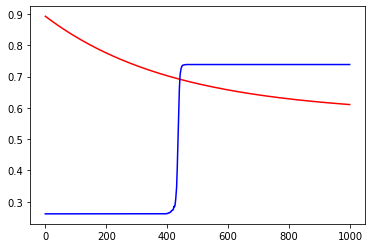

Loss before training 0.892848789691925
Loss after training 0.6106334328651428


In [602]:
device = torch.device("cuda:0")

model = Net()

train(model, x_train, y_train, lr=0.001, epochs=1000, device=device)

In [201]:
X_valid = x_val.float()
Y_valid = y_val.long()

In [604]:
# for i in range(10):
arr = np.array([390,506,318,0])
arr = torch.from_numpy(arr)
arr = arr.float().to(device)

with torch.no_grad():
    pred = model(arr)
    print(F.softmax(pred, dim=-1).cpu().numpy())

[0.61648476 0.3835152 ]


# Extras

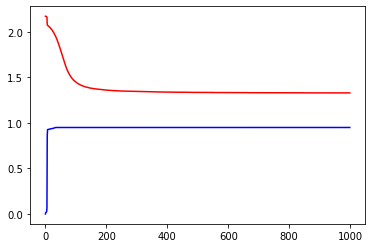

Loss before training 2.1716325283050537
Loss after training 1.3293184041976929


In [242]:
torch.manual_seed(0)
weights1 = torch.randn(4, 4) / math.sqrt(2)
weights1.requires_grad_()
bias1 = torch.zeros(4, requires_grad=True)

weights2 = torch.randn(4, 8) / math.sqrt(2)
weights2.requires_grad_()
bias2 = torch.zeros(8, requires_grad=True)

learning_rate = 0.2
epochs = 1000

loss_arr = []
acc_arr = []

for epoch in range(epochs):
  y_hat = model(X_train)
  loss = F.cross_entropy(y_hat, Y_train)
  loss.backward()
  loss_arr.append(loss.item())
  acc_arr.append(accuracy(y_hat, Y_train))

  with torch.no_grad():
    weights1 -= weights1.grad * learning_rate
    bias1 -= bias1.grad * learning_rate
    weights2 -= weights2.grad * learning_rate
    bias2 -= bias2.grad * learning_rate
    weights1.grad.zero_()
    bias1.grad.zero_()
    weights2.grad.zero_()
    bias2.grad.zero_()

plt.plot(loss_arr, 'r-')
plt.plot(acc_arr, 'b-')
plt.show()
print('Loss before training', loss_arr[0])
print('Loss after training', loss_arr[-1])

In [204]:
class FirstNetwork(nn.Module):
  
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.weights1 = nn.Parameter(torch.randn(4, 4) / math.sqrt(2))
    self.bias1 = nn.Parameter(torch.zeros(4))
    self.weights2 = nn.Parameter(torch.randn(4, 8) / math.sqrt(2))
    self.bias2 = nn.Parameter(torch.zeros(8))
    
  def forward(self, X):
    a1 = torch.matmul(X, self.weights1) + self.bias1
    h1 = a1.sigmoid()
    a2 = torch.matmul(h1, self.weights2) + self.bias2
    h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1)
    return h2

In [211]:
def fit(epochs = 1000, learning_rate = 0.2):
  loss_arr = []
  acc_arr = []
  for epoch in range(epochs):
    y_hat = fn(X_train)
    loss = F.cross_entropy(y_hat, Y_train)
    loss_arr.append(loss.item())
    acc_arr.append(accuracy(y_hat, Y_train))

    loss.backward()
    with torch.no_grad():
      for param in fn.parameters():
        param -= learning_rate * param.grad
      fn.zero_grad()
        
  plt.plot(loss_arr, 'r-')
  plt.plot(acc_arr, 'b-')
  plt.show()      
  print('Loss before training', loss_arr[0])
  print('Loss after training', loss_arr[-1])

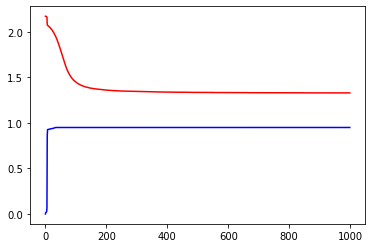

Loss before training 2.1716325283050537
Loss after training 1.3293184041976929


In [212]:
fn = FirstNetwork()
fit()

In [213]:
class FirstNetwork_v1(nn.Module):
  
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.lin1 = nn.Linear(4, 4)
    self.lin2 = nn.Linear(4, 8)
    
  def forward(self, X):
    a1 = self.lin1(X)
    h1 = a1.sigmoid()
    a2 = self.lin2(h1)
    h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1)
    return h2

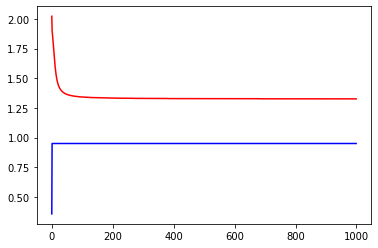

Loss before training 2.0221312046051025
Loss after training 1.3257406949996948


In [214]:
fn = FirstNetwork_v1()
fit()

In [216]:
def fit_v1(epochs = 1000, learning_rate = 0.2):
  loss_arr = []
  acc_arr = []
  opt = optim.SGD(fn.parameters(), lr=learning_rate)
  
  for epoch in range(epochs):
    y_hat = fn(X_train)
    loss = F.cross_entropy(y_hat, Y_train)
    loss_arr.append(loss.item())
    acc_arr.append(accuracy(y_hat, Y_train))

    loss.backward()
    opt.step()
    opt.zero_grad()
        
  plt.plot(loss_arr, 'r-')
  plt.plot(acc_arr, 'b-')
  plt.show()      
  print('Loss before training', loss_arr[0])
  print('Loss after training', loss_arr[-1])

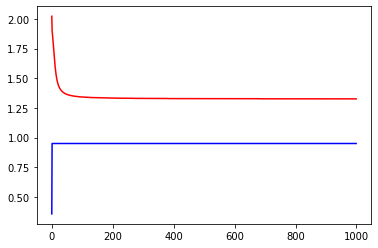

Loss before training 2.0221312046051025
Loss after training 1.3257406949996948


In [217]:
fn = FirstNetwork_v1()
fit_v1()

In [219]:
class FirstNetwork_v2(nn.Module):
  
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.net = nn.Sequential(
        nn.Linear(4, 4), 
        nn.Sigmoid(), 
        nn.Linear(4, 8), 
        nn.Softmax()
    )

  def forward(self, X):
    return self.net(X)

/home/krishna/miniconda3/envs/padhai/lib/python3.7/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


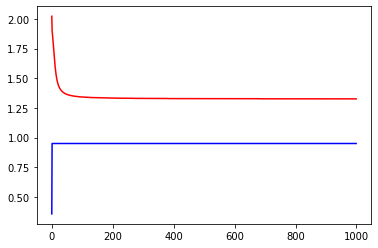

Loss before training 2.0221312046051025
Loss after training 1.3257406949996948


In [220]:
fn = FirstNetwork_v2()
fit_v1()

In [221]:
def fit_v2(x, y, model, opt, loss_fn, epochs = 1000):
  
  for epoch in range(epochs):
    loss = loss_fn(model(x), y)

    loss.backward()
    opt.step()
    opt.zero_grad()
    
  return loss.item()

In [223]:
fn = FirstNetwork_v2()
loss_fn = F.cross_entropy
opt = optim.SGD(fn.parameters(), lr=0.2)
fit_v2(X_train, Y_train, fn, opt, loss_fn)

1.3257406949996948

In [226]:
device = torch.device("cuda")

X_train=X_train.to(device)
Y_train=Y_train.to(device)
fn = FirstNetwork_v2()
fn.to(device)
tic = time.time()
print('Final loss', fit_v2(X_train, Y_train, fn, opt, loss_fn))
toc = time.time()
print('Time taken', toc - tic)

Final loss 2.0220627784729004
Time taken 0.8134410381317139


In [227]:
class FirstNetwork_v3(nn.Module):
  
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.net = nn.Sequential(
        nn.Linear(4, 1024*4), 
        nn.Sigmoid(), 
        nn.Linear(1024*4, 4), 
        nn.Softmax()
    )

  def forward(self, X):
    return self.net(X)

In [228]:
device = torch.device("cuda")

X_train=X_train.to(device)
Y_train=Y_train.to(device)
fn = FirstNetwork_v3()
fn.to(device)
tic = time.time()
print('Final loss', fit_v2(X_train, Y_train, fn, opt, loss_fn))
toc = time.time()
print('Time taken', toc - tic)

Final loss 1.2908447980880737
Time taken 12.28536605834961


In [236]:
arr = np.array([465,511,323,51])

In [237]:
arr = torch.from_numpy(arr)